# Deep Hedging AI
### Vanilla Deep Hedging engine reference implementation with dynamic training update.
### Example notebook for recurrent networks.

Hans Buehler, January 8th, 2023


In [1]:
""" Slighly annoying: by default the SageMaker Python import directory does not include our git directory """
import os
p = os.getcwd()
dhn = "/deephedging/"
i = p.find(dhn)
if i!=-1:
    p = p[:i]
    import sys
    sys.path.append(p)
    print("SageMaker: added python path %s" % p)

Deep Hedging AI says hello ... Tensorflow version 2.7.0 running on 1 CPUs and 0 GPUs


## Deep Hedging in a Black \& Scholes World

Gym with 943 trainable weights compiled and initialized. Took 13s
Network feature information:
 Features used by the agent:        delta, price and time_left
 Features available to the agent:   action, cost, delta, ivol, lbnd_a, pnl, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by the utility:      -
 Features available to the utility: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
Caching enabled @ 'C:/Users/hansb/iCloudDrive/Python3/deephedging/notebooks/.deephedging_cache/1d5b91ec5a1dce6afb78d26c9075d5e3.pck'
Training monitor initialized. Took 0s
                                                                                                                                                                                                         


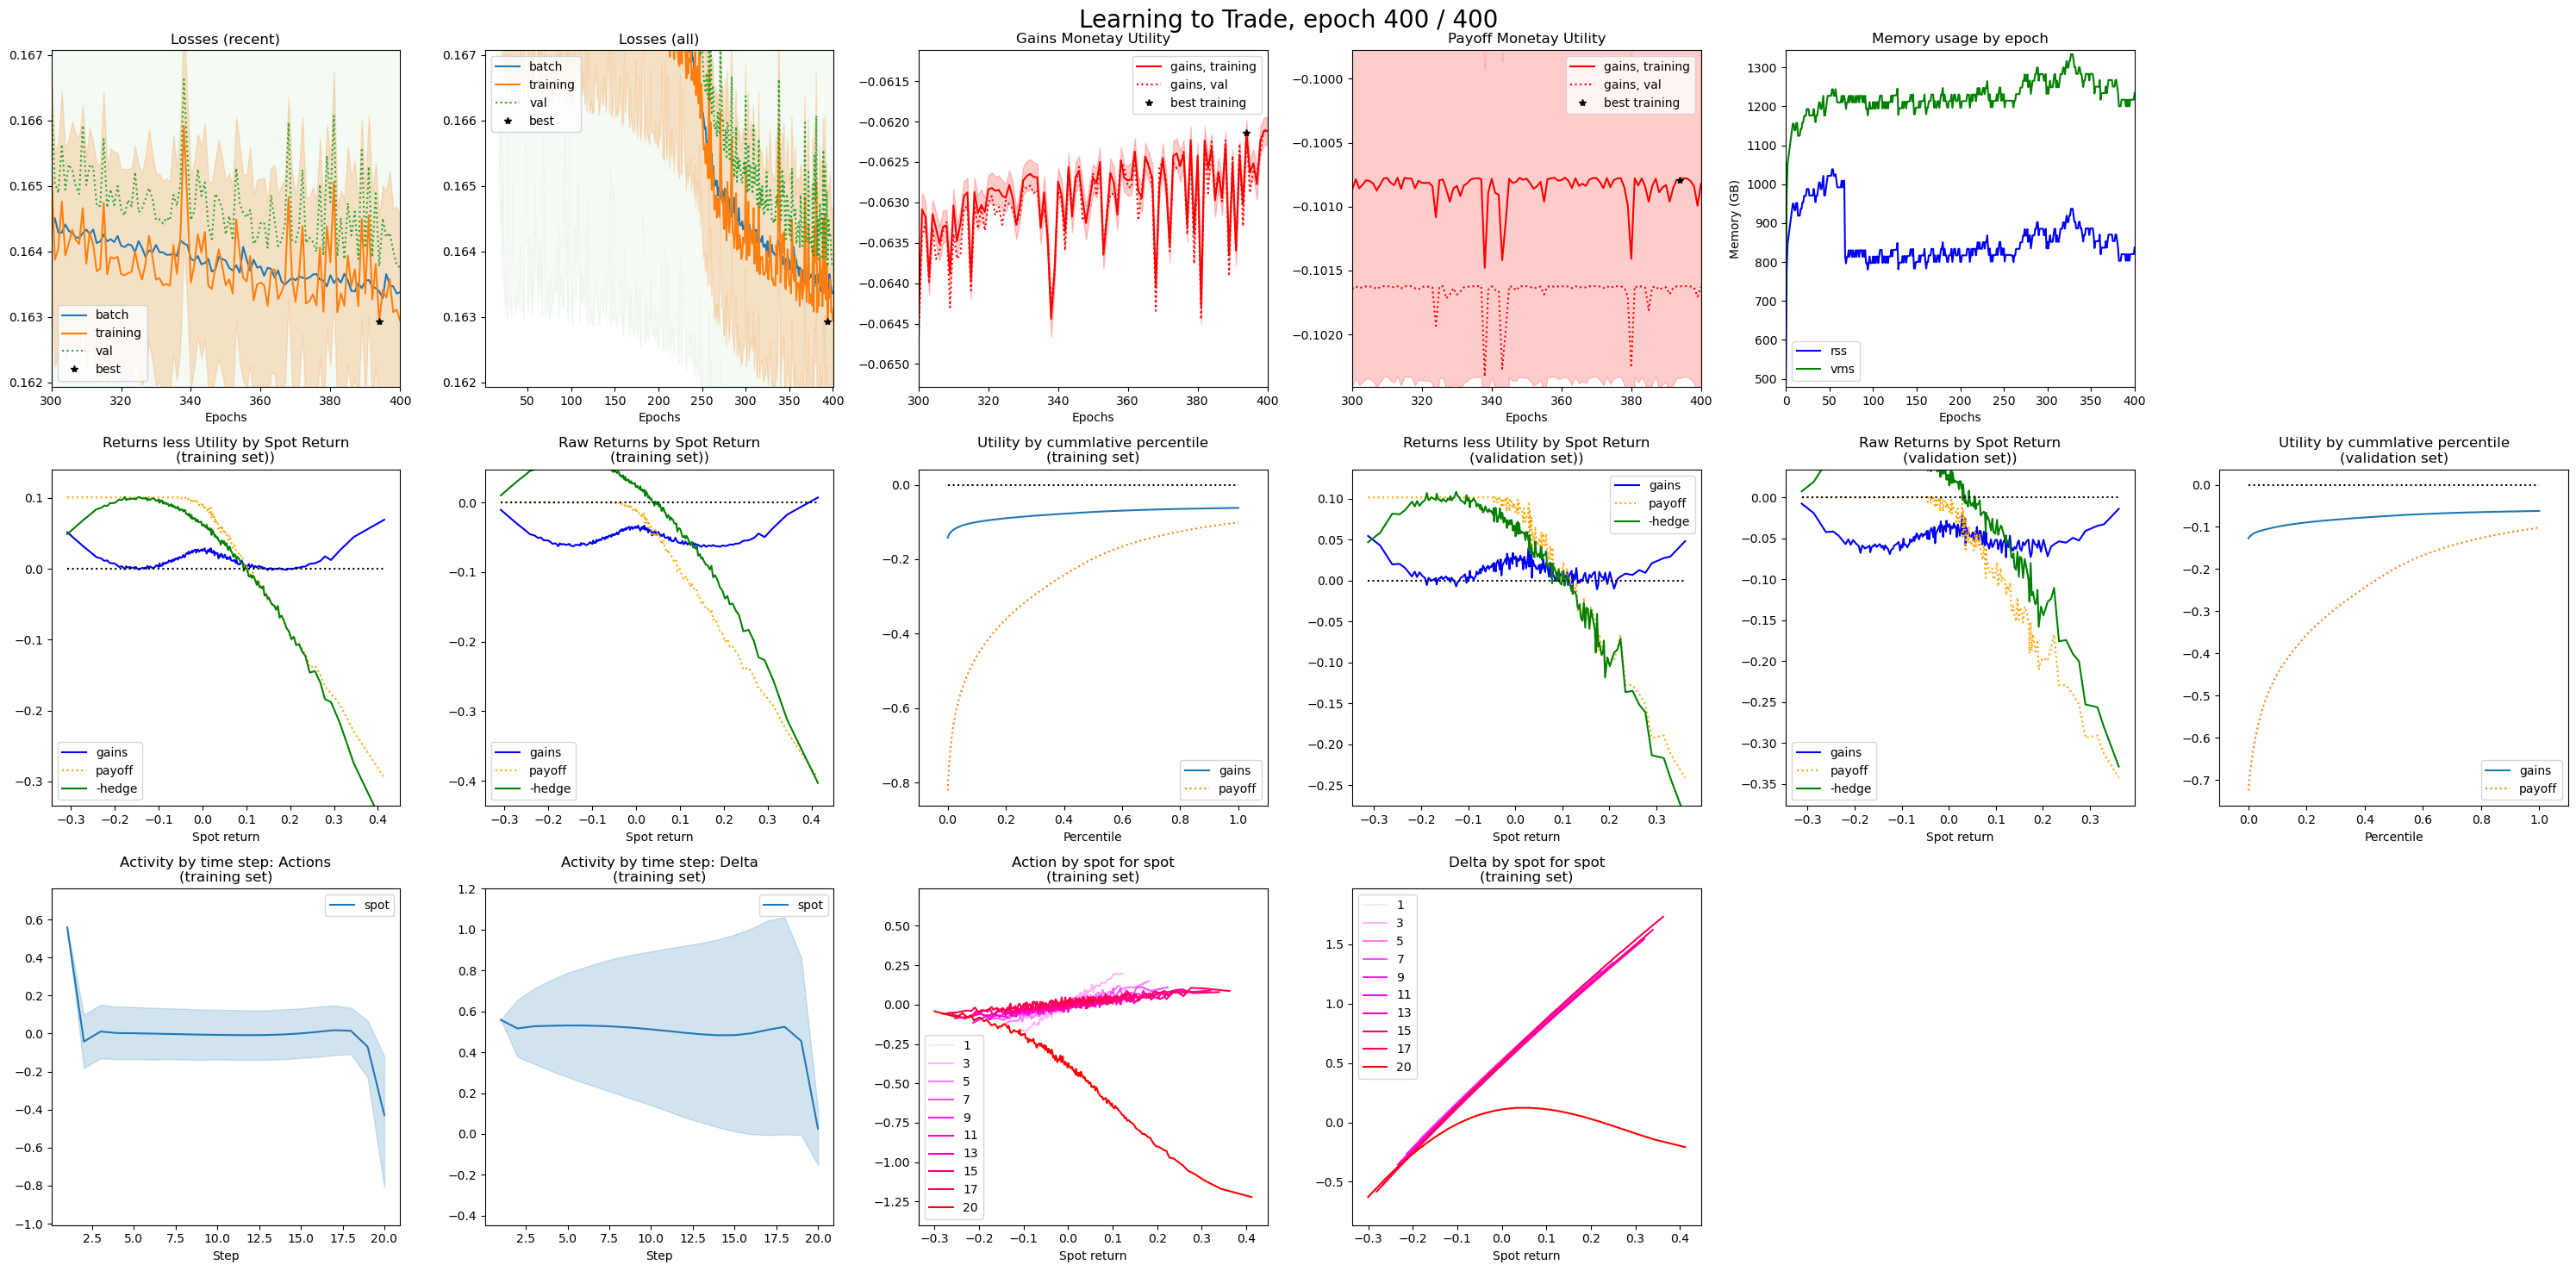

Training 400/400 epochs; 943 weights; 10000 samples; 1000 validation samples batch size 32 | initial loss 0.883015 (0.0133979), training 0.16294 (0.00159105), best 0.162936 (0.0133979), batch 0.163376, val 0.163755 (0.00486566). Best epoch 393; last cached 399. | memory used: rss 837.051M, vms 1233.7M | time elapsed 2:28:24; time per epoch 22s; estimated time remaining 2:28:24                          
 Status: Training complete.
 Weights set to best epoch: 393
 State of training until epoch 399 cached into C:/Users/hansb/iCloudDrive/Python3/deephedging/notebooks/.deephedging_cache/1d5b91ec5a1dce6afb78d26c9075d5e3.pck

Training terminated. Total time taken 3:04:06
Keys of the dictionary returned by the gym:  odict_keys(['loss', 'utility', 'utility0', 'gains', 'payoff', 'pnl', 'cost', 'actions'])
Config usage report
config.gym.agent.network['activation'] = softplus # Network activation function; default: relu
config.gym.agent.network['depth'] = 3 # Network depth; default: 3
config.gym.a

In [2]:
print("Deep Hedging AI says hello ... ", end='')
from cdxbasics.config import Config
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM

from IPython.display import display, Markdown

# see print of the config below for numerous options
config = Config()
# world
config.world.samples = 10000
config.world.steps = 20
config.world.black_scholes = True
# gym
config.gym.objective.utility = "cvar"
config.gym.objective.lmbda = 1.
config.gym.agent.network.depth = 3
config.gym.agent.network.depth = 3
config.gym.agent.network.activation = "softplus"

from tensorflow.keras import optimizers
opt = optimizers.Adam( clipvalue=0.5, global_clipnorm = 10.)

config.trainer.train.optimizer = opt
config.trainer.train.batch_size = None
config.trainer.train.epochs = 400
config.trainer.caching.mode = "on"
config.trainer.visual.epoch_refresh = 1
config.trainer.visual.time_refresh = 10
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75

display(Markdown("## Deep Hedging in a Black \& Scholes World"))

# create world
world  = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=1000)

# create training environment
gym = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
r = gym(world.tf_data)
print("Keys of the dictionary returned by the gym: ", r.keys())

print("=========================================")
print("Config usage report")
print("=========================================")
print( config.usage_report() )
config.done()

#### Comparison to Black & Scholes

See also notebooks/blackscholes for other notebooks. Note that we use medium risk aversion, hence the hedge is not expected to match the risk-neutral hedge. See the sub directory <tt>blackscholes</tt> for experiments approximating the black & scholes solution

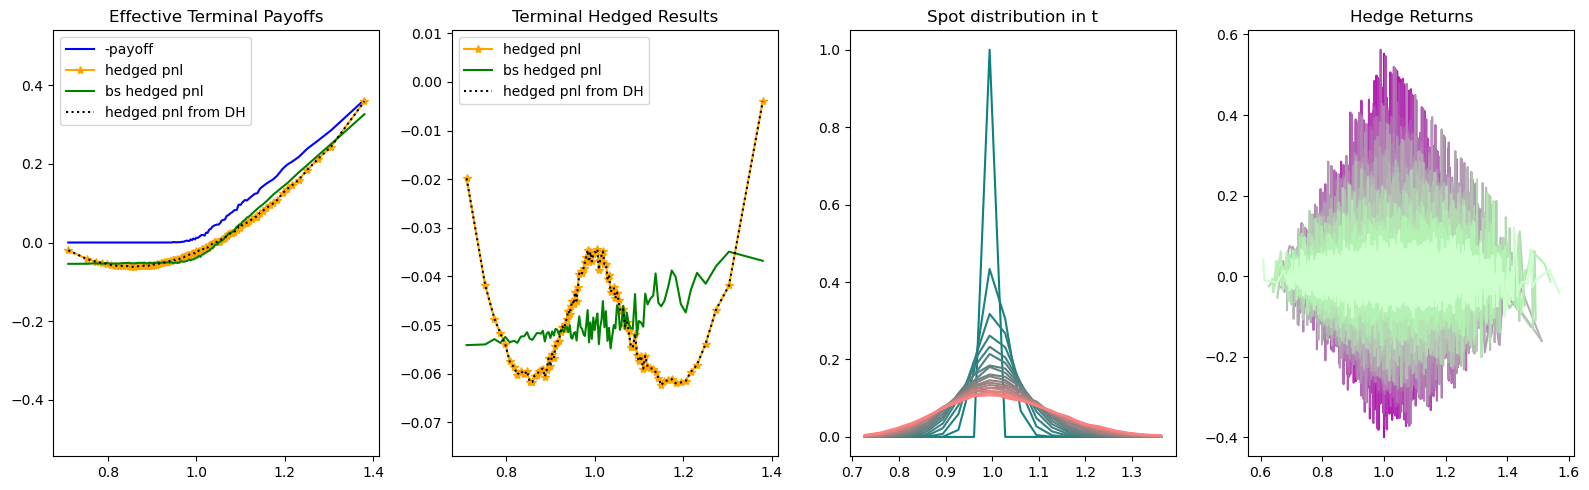

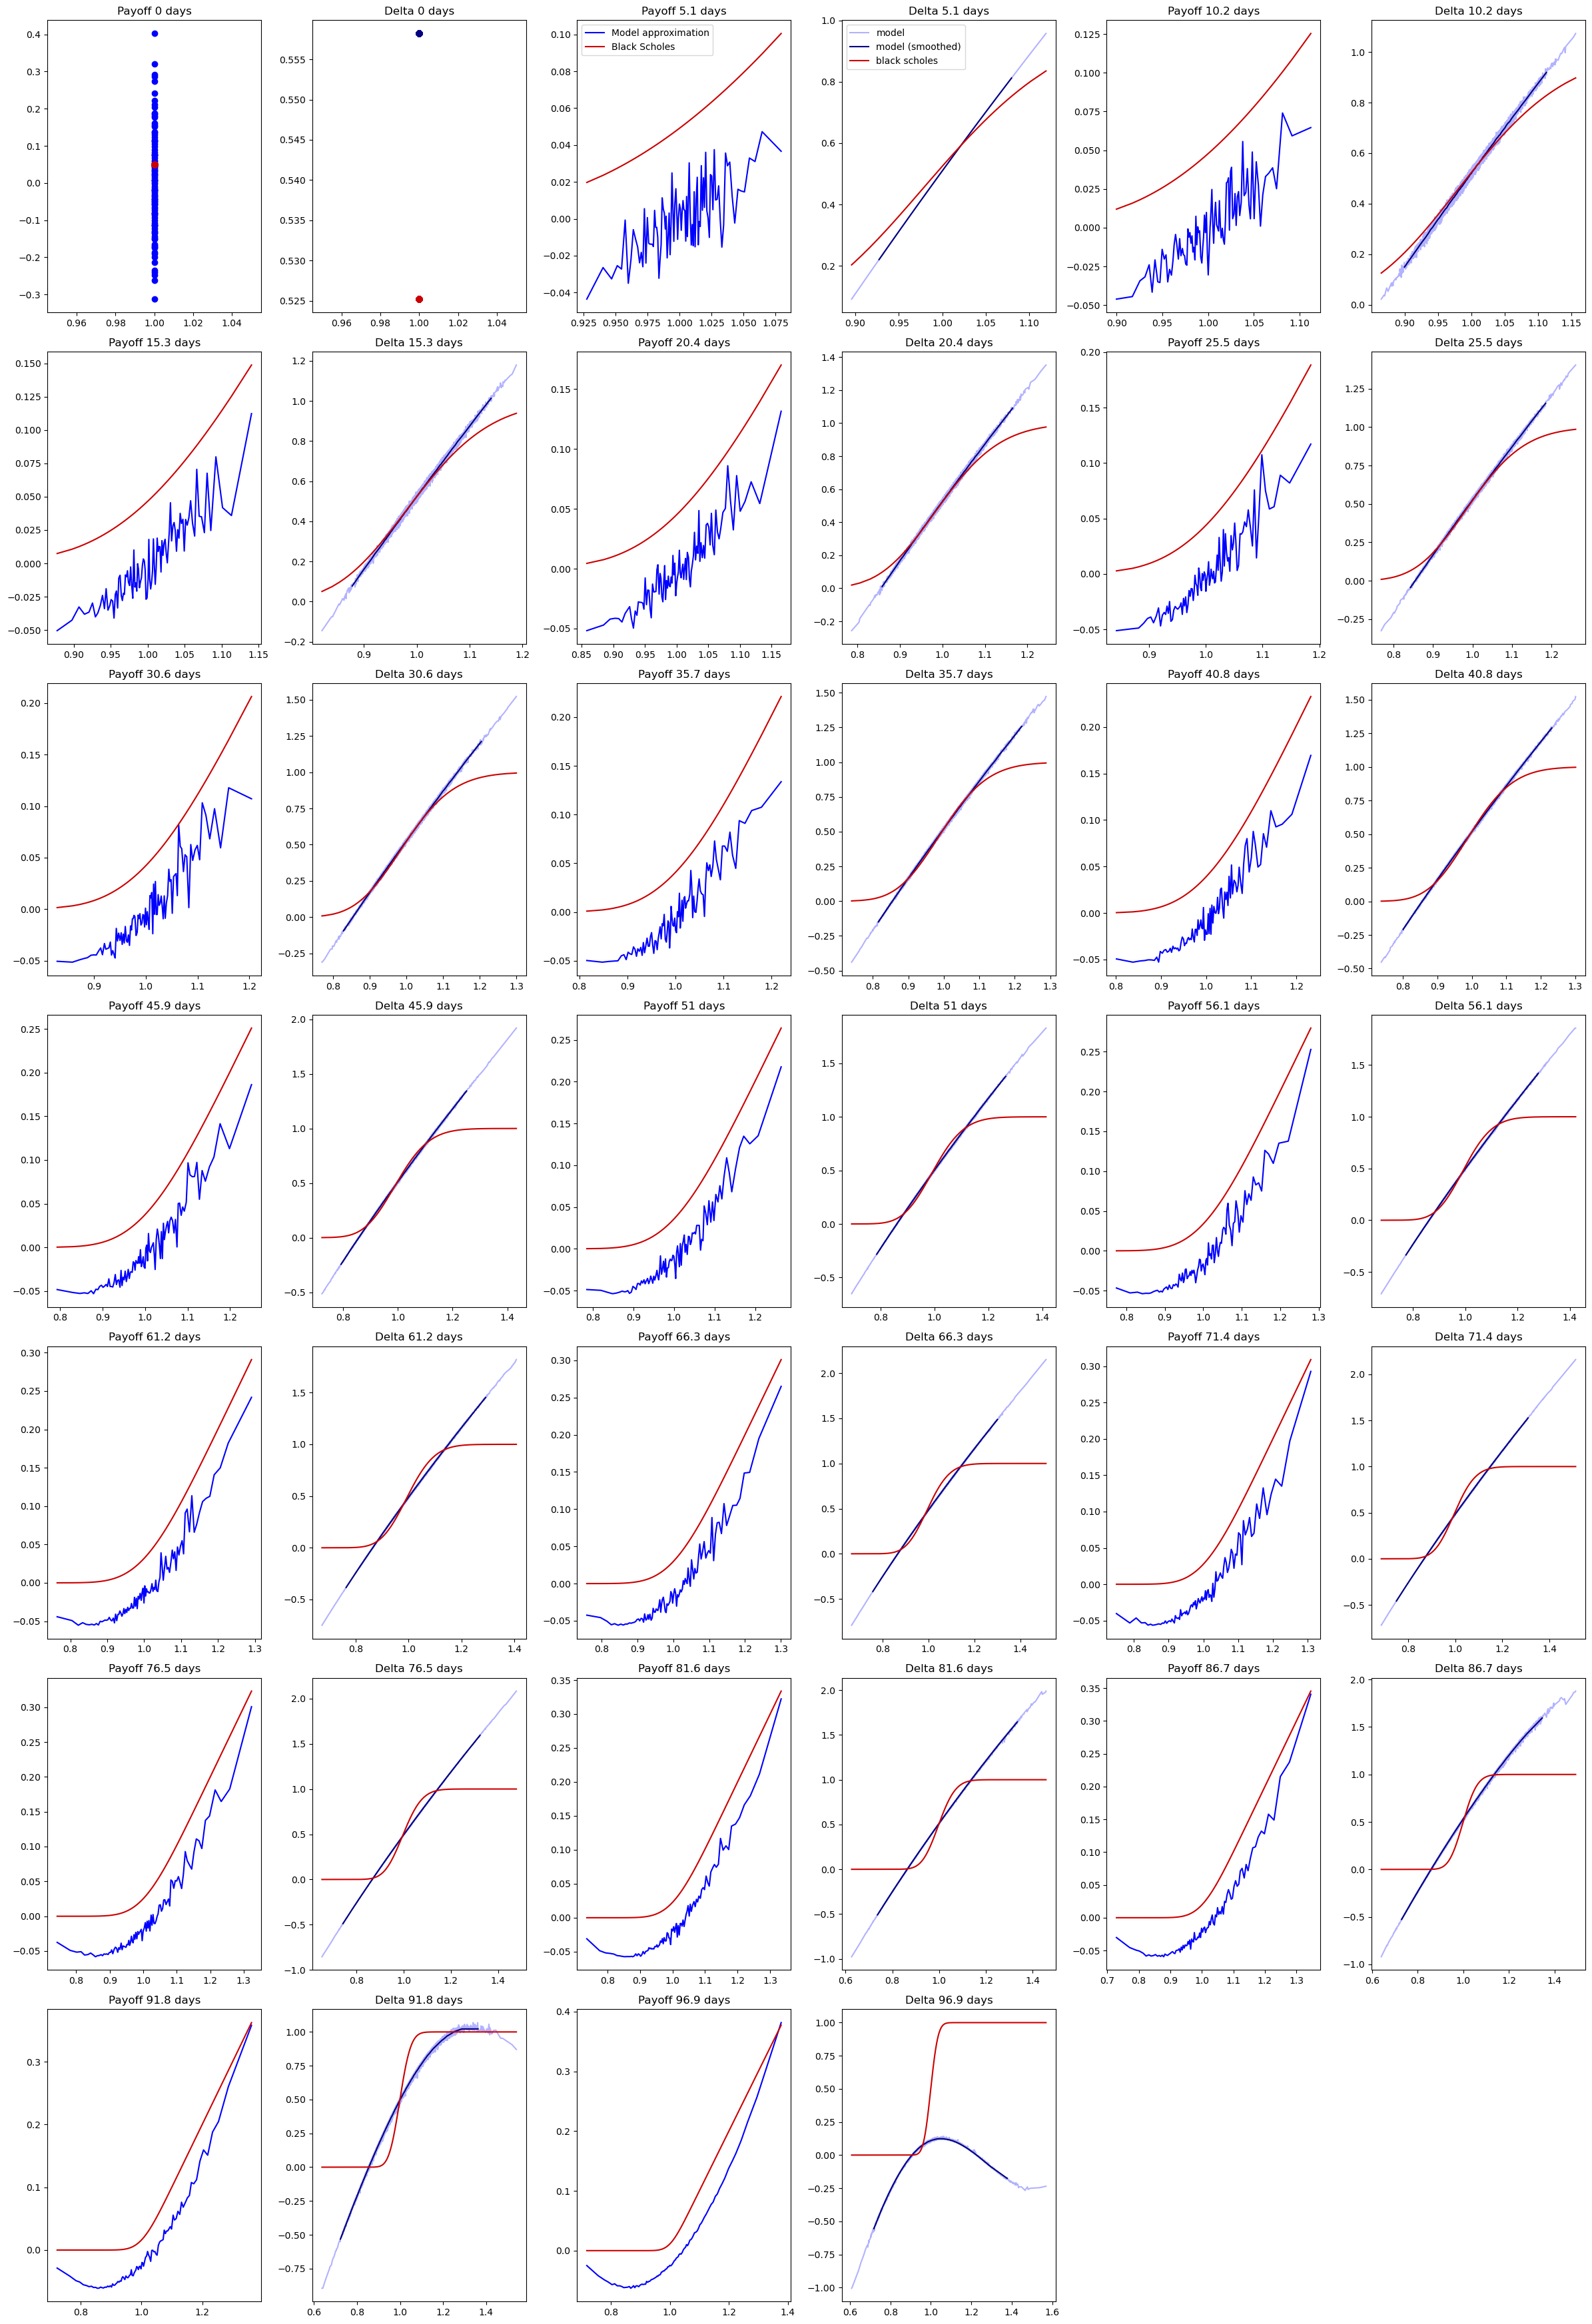

In [3]:
import deephedging.plot_bs_hedge as plot_bs_hedge
import imp
imp.reload(plot_bs_hedge)

plot_bs_hedge.plot_blackscholes( world, gym, config )

## Stochastic Vol
### Trading with two assets

Deep Hedging AI says hello  ... 

## Deep Hedging in a simple Stochastic Volatility World

Gym with 1424 trainable weights compiled and initialized. Took 6s
Network feature information:
 Features used by the agent:        delta, price and time_left
 Features available to the agent:   action, call_delta, call_price, call_vega, cost, cost_v, delta, ivol, lbnd_a, pnl, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by the utility:      -
 Features available to the utility: call_delta, call_price, call_vega, cost, cost_v, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
Caching enabled @ 'C:/Users/hansb/iCloudDrive/Python3/deephedging/notebooks/.deephedging_cache/695995b595515b3cd4d7b03b3e3027a7.pck'
Training monitor initialized. Took 0s
                                                                                                                                                                                                         


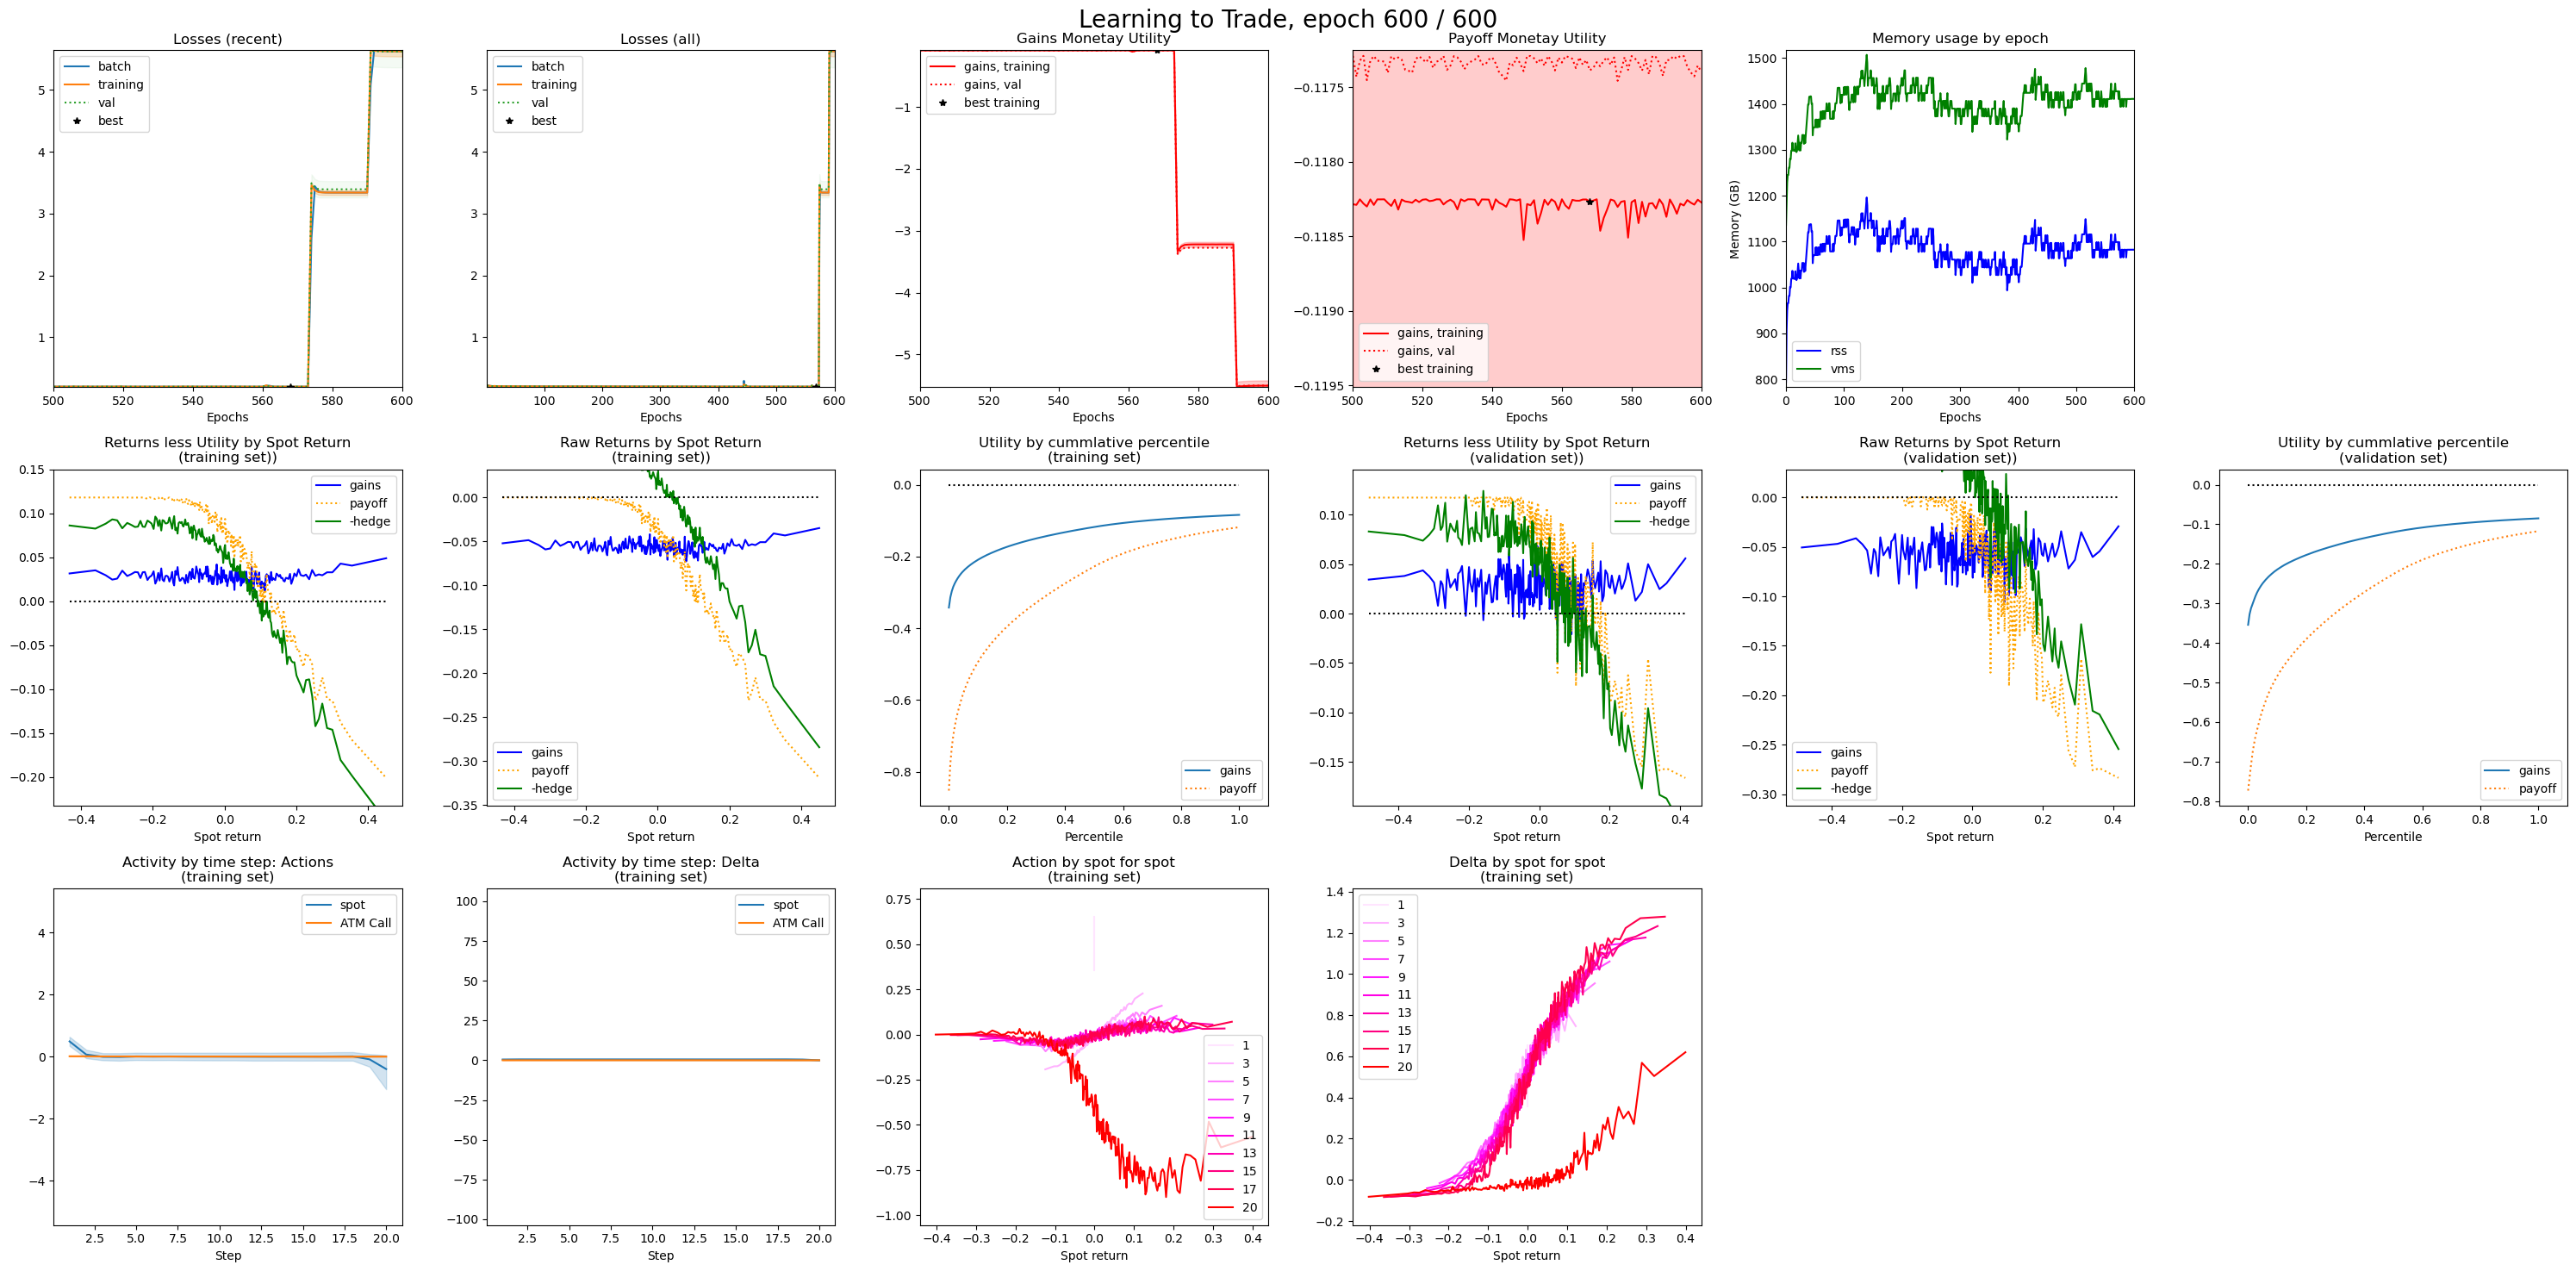

Training 600/600 epochs; 1424 weights; 10000 samples; 1000 validation samples batch size 32 | initial loss 0.326756 (0.00445858), training 5.62251 (0.0842619), best 0.202221 (0.00445858), batch 5.6227, val 5.62018 (0.258492). Best epoch 567; last cached 599. | memory used: rss 1082.28M, vms 1410.82M | time elapsed 3:29:44; time per epoch 20s; estimated time remaining 3:29:44                               
 Status: Training complete.
 Weights set to best epoch: 567
 State of training until epoch 599 cached into C:/Users/hansb/iCloudDrive/Python3/deephedging/notebooks/.deephedging_cache/695995b595515b3cd4d7b03b3e3027a7.pck

Training terminated. Total time taken 4:11:58
Keys of the dictionary returned by the gym:  odict_keys(['loss', 'utility', 'utility0', 'gains', 'payoff', 'pnl', 'cost', 'actions'])
Config usage report
config.gym.agent.network['activation'] = softplus # Network activation function; default: relu
config.gym.agent.network['depth'] = 3 # Network depth; default: 3
config.gy

In [4]:
print("Deep Hedging AI says hello  ... ", end='')
from cdxbasics.config import Config
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM
import tensorflow as tf

from IPython.display import display, Markdown

# see print of the config below for numerous options
config = Config()
# world
config.world.samples = 10000
config.world.steps = 20
config.world.black_scholes = False
# gym
config.gym.objective.utility = "cvar"
config.gym.objective.lmbda = 1.
config.gym.agent.recurrence = 10
config.gym.agent.network.depth = 3
config.gym.agent.network.activation = "softplus"
# trainer
from tensorflow.keras import optimizers
opt = optimizers.Adam( clipvalue=0.5, global_clipnorm = 10.)

config.trainer.train.optimizer = opt
config.trainer.train.batch_size = None
config.trainer.train.epochs = 600
config.trainer.caching.mode = "on"
config.trainer.train.run_eagerly = None
config.trainer.visual.epoch_refresh = 1
config.trainer.visual.time_refresh = 10
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75

display(Markdown("## Deep Hedging in a simple Stochastic Volatility World"))

# create world
world  = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=1000)

# create training environment
tf.debugging.enable_check_numerics()
gym = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
r = gym(world.tf_data)
print("Keys of the dictionary returned by the gym: ", r.keys())

print("=========================================")
print("Config usage report")
print("=========================================")
print( config.usage_report() )
config.done()